# PMFG -- Centrality Measures Analysis
#### M Chu
Adapted from `playground.ipynb`.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from PMFG_mod import PMFG

from time import time
import timeit

#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Importing data
Data downloaded from WRDS and preprocessed.

# NOTE
for large rolling window, we can replicate the centrality feature-clustering phenomenon described in Pozzi. But for smaller rolling window (say half a year), things get messier, and the clustering is much less apparent.

In [2]:
use_IVV = False

if use_IVV:
    raw_asset_prices_df = pd.read_csv("IVV_historical.csv", index_col='Date')

    log_returns_df = np.log(raw_asset_prices_df).diff().dropna()
    # drop first row of raw prices so it has the same dimensions as the log-returns DF
    raw_asset_prices_df = raw_asset_prices_df.iloc[1:]
    stock_names = log_returns_df.columns

    df_shape = (raw_asset_prices_df.shape)
    print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
    print(f"Data timeperiod covers: {raw_asset_prices_df.index[0]} to {raw_asset_prices_df.index[-1]}")

    print(log_returns_df.head())
else:
    log_returns_df = pd.read_excel("data/historical_2016_2019.xlsx", index_col='Names Date')
    stock_names = log_returns_df.columns   # this is just simple returns, not log -- but whatevs
    df_shape = (log_returns_df.shape)
    print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
    print(f"Data timeperiod covers: {log_returns_df.index[0]} to {log_returns_df.index[-1]}")
    
ticker_names = log_returns_df.columns

There are 1006 rows and 485 columns in the dataset.
Data timeperiod covers: 2016-01-04 00:00:00 to 2019-12-31 00:00:00


In [3]:
log_returns_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Names Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.026788,-0.034002,0.011494,0.000855,-0.027515,-0.017742,-0.055826,-0.044088,-0.025550,-0.020971,...,-0.005848,-0.024910,-0.006286,-0.032703,-0.011507,-0.011499,-0.007603,-0.045370,-0.021612,-0.013564
2016-01-05,-0.003441,-0.009533,-0.006831,-0.025059,-0.004166,0.014626,-0.002816,-0.000233,0.005205,0.004023,...,0.010084,0.014847,0.008521,0.020387,-0.000277,-0.002493,0.020823,-0.025117,-0.010857,0.015655
2016-01-06,0.004439,0.017522,-0.026455,-0.019570,0.000174,-0.015286,0.003529,-0.008388,-0.001954,-0.014295,...,0.010538,-0.018287,-0.008321,-0.014486,-0.012476,-0.007080,0.004330,-0.039957,-0.029145,0.000208
2016-01-07,-0.042475,-0.018918,0.011073,-0.042205,-0.002963,-0.031932,-0.039625,-0.023966,-0.029366,-0.020984,...,0.003842,-0.039448,-0.016006,-0.008785,-0.025828,-0.034116,-0.022993,-0.045316,-0.030020,-0.030404
2016-01-08,-0.010513,-0.001978,-0.021971,0.005288,-0.027268,-0.005785,0.032471,-0.020944,-0.009681,-0.014140,...,-0.010935,-0.020534,-0.020202,-0.028635,-0.009510,-0.013607,-0.004217,-0.002693,-0.011254,-0.014605


## Construction of correlation matrix

In [4]:
#tshift = 252
#raw_corr = log_returns_df.iloc[tshift:126+tshift].corr()
raw_corr = log_returns_df.corr()

shr_coef = 1e-4
#shr_target=np.ones((df_shape[1], df_shape[1]))
shr_target=np.eye(df_shape[1])

correlation_matrix = raw_corr*(1-shr_coef) + shr_target*shr_coef
print('Condition number of sample correlation matrix: %.2e' %np.linalg.cond(raw_corr))
print('Condition number of shrunk correlation matrix: %.2e' %np.linalg.cond(correlation_matrix))
correlation_matrix.head()

Condition number of sample correlation matrix: 4.51e+04
Condition number of shrunk correlation matrix: 4.36e+04


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.382898,0.174961,0.423588,0.371440,0.268825,0.370766,0.574714,0.524620,0.524594,...,0.082312,0.390005,0.344952,0.305398,0.495933,0.383953,0.426343,0.385791,0.402954,0.508536
AAL,0.382898,1.000000,0.202168,0.349767,0.212754,0.242920,0.208959,0.356430,0.336261,0.357479,...,-0.061541,0.401709,0.242301,0.195624,0.393245,0.300815,0.274667,0.333879,0.422293,0.330460
AAP,0.174961,0.202168,1.000000,0.155419,0.147060,0.162803,0.134836,0.215587,0.215358,0.151175,...,0.068318,0.154732,0.180567,0.123950,0.209004,0.176603,0.188930,0.172971,0.265356,0.191637
AAPL,0.423588,0.349767,0.155419,1.000000,0.271367,0.206464,0.363831,0.425138,0.461773,0.513189,...,0.031991,0.442036,0.343888,0.223976,0.365499,0.315368,0.321466,0.350361,0.302726,0.384876
ABBV,0.371440,0.212754,0.147060,0.271367,1.000000,0.304759,0.258362,0.431498,0.328579,0.328576,...,0.059929,0.241190,0.292893,0.261174,0.302585,0.199634,0.334430,0.222451,0.278699,0.380533


D:\Anaconda\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


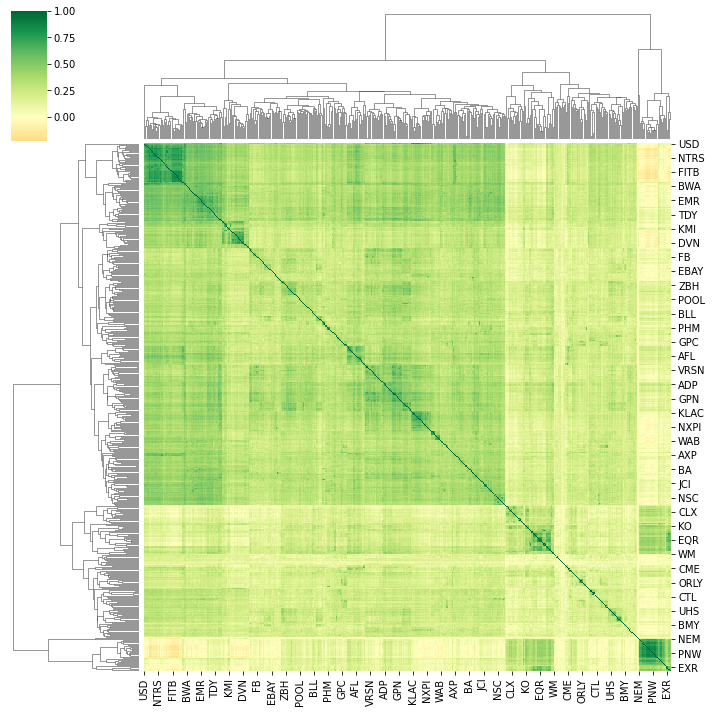

In [5]:
sns.clustermap(correlation_matrix, cmap="RdYlGn", center =0.)
plt.show();

## Graph construction and centrality/peripherality measures
Interestingly, from Pozzi et al., they used different edge weights for each centrality/peripherality meaures.

Pipeline:

1. Construct correlation matrix (for each tick, say, daily data)
    * Robust est. and shrinkage sorely needed
2. Use (off-diagonal) corr. as adjacency matrix;  construct MST/PMFG.etc
3. transform edge weights
    * $R_{ij} \mapsto 1+R_{ij}$ for Deg and Eig-Centrality
    * $R_{ij} \mapsto \sqrt{2(1-R_{ij})}$ for BC, Closeness, and Eccentricity
    * Can also make the graph unweighted; Pozzi reported similar results for weighted/unweighted graphs
4. report centrality/peripherality measures for each node
    * Betweeness-centrality, eccentricity .etc
5. Aggregate the measures; analyze and compose hybrid cen/per index



Centrality/peripherality measures: 
* degree 
* betweenness-centrality
* eccentricity
* closeness
* eigenvector-centrality

In [6]:
G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
print(nx.info(G0))
print('Sanity check: edge weights are non-binary...')
nx.adjacency_matrix(G0)[0,1]
#nx.draw(G0, with_labels=True, node_size=700, node_color="#e1575c", edge_color='#363847',  pos=nx.spectral_layout(Gt1))

Name: 
Type: Graph
Number of nodes: 485
Number of edges: 117370
Average degree: 484.0000
Sanity check: edge weights are non-binary...


0.3828978956166804

In [7]:
timestamp = time()
G0_filtered = PMFG(G0).compute(tol_ratio=.03)
print('Time taken to construct PMFG graph: %.2f s\n' %(time()-timestamp))
print(nx.info(G0_filtered))

# check that the MST is weighted:
#G0_filtered.edges('AAPL')
G0_filtered.adj['AAPL']

Time taken to construct PMFG graph: 60.54 s

Name: 
Type: Graph
Number of nodes: 476
Number of edges: 1406
Average degree:   5.9076


AtlasView({'USD': {'weight': 0.6309549601250133}, 'SWKS': {'weight': 0.604107929796799}, 'QRVO': {'weight': 0.5367252469071289}})

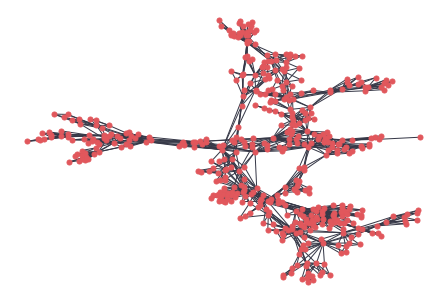

In [8]:
nx.draw(G0_filtered, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.fruchterman_reingold_layout(G0_filtered))

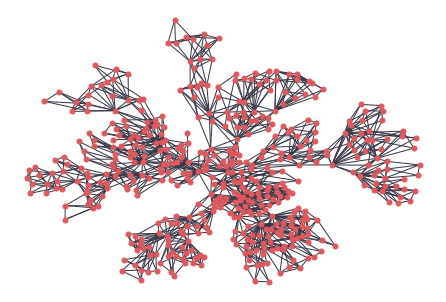

In [9]:
nx.draw(G0_filtered, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.kamada_kawai_layout(G0_filtered))

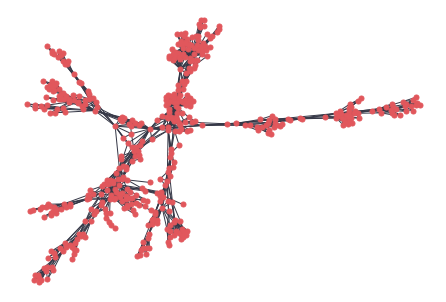

In [10]:
nx.draw(G0_filtered, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spring_layout(G0_filtered, iterations=500))

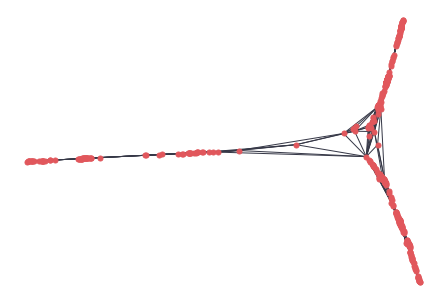

In [11]:
nx.draw(G0_filtered, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spectral_layout(G0_filtered))

In [12]:
G1 = nx.Graph()
print(nx.info(G1))
weight_map = lambda w: 1+w
for u,v,d in G0_filtered.edges(data=True):
    G1.add_edge(u,v,weight=weight_map(d['weight']))
print(nx.info(G1))

deg= pd.DataFrame.from_dict(dict(G1.degree(weight='weight')), orient='index', columns = ['D'])
# for eigen-centrality, can tune max_iter and weight=None/'weight'
# so far, no noticeable by tuning these params
EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(G1, weight='weight', max_iter=1000), orient='index', columns = ['EC'])
#EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(G1), orient='index', columns = ['EC'])

PG = pd.DataFrame.from_dict(nx.pagerank(G1, weight='weight'), orient='index', columns = ['PG'])

Name: 
Type: Graph
Number of nodes: 0
Number of edges: 0

Name: 
Type: Graph
Number of nodes: 476
Number of edges: 1406
Average degree:   5.9076


In [13]:
G1 = nx.Graph()
print(nx.info(G1))
weight_map = lambda w: np.sqrt(2*(1-w))
for u,v,d in G0_filtered.edges(data=True):
    G1.add_edge(u,v,weight=weight_map(d['weight']))
print(nx.info(G1))

use_weighted = True
if use_weighted:
    ecc= pd.DataFrame.from_dict(nx.eccentricity(G1), orient='index', columns = ['E'])
    clo= pd.DataFrame.from_dict(nx.closeness_centrality(G1), orient='index', columns = ['C'])
    BC = pd.DataFrame.from_dict(nx.betweenness_centrality(G1), orient='index', columns = ['BC'])
else:
    ecc= pd.DataFrame.from_dict(nx.eccentricity(G1), orient='index', columns = ['E'])
    clo= pd.DataFrame.from_dict(nx.closeness_centrality(G1, distance='weight'), orient='index', columns = ['C'])
    BC = pd.DataFrame.from_dict(nx.betweenness_centrality(G1, weight='weight'), orient='index', columns = ['BC'])

Name: 
Type: Graph
Number of nodes: 0
Number of edges: 0

Name: 
Type: Graph
Number of nodes: 476
Number of edges: 1406
Average degree:   5.9076


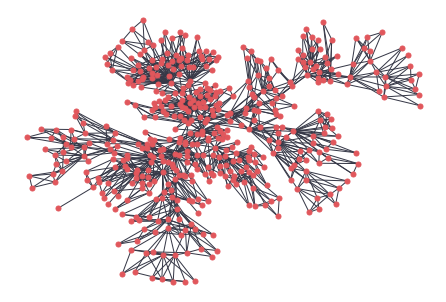

In [14]:
nx.draw(G1, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.kamada_kawai_layout(G1))

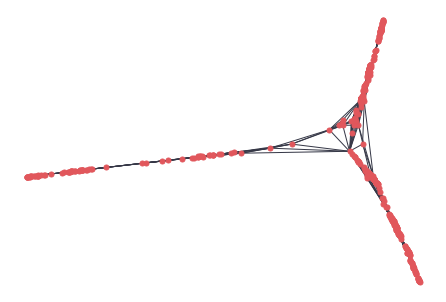

In [15]:
#nx.draw(G1, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.fruchterman_reingold_layout(G1))
nx.draw(G1, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spectral_layout(G1))
#nx.draw(G1, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spring_layout(G1, iterations=500))

In [16]:
#centralities_names = ['BC', 'C', 'D', 'E', 'EC']
#centralities_names = ['D', 'BC', 'E', 'C', 'EC']
centralities_names = ['D', 'BC', 'nE', 'C', 'EC', 'PG']

centralities = deg.copy()
centralities['BC'] = BC
centralities['nE']  = -ecc
centralities['C']  = clo
centralities['EC'] = EC
centralities['PG'] = PG

print(centralities.head())

               D        BC  nE         C        EC        PG
GOOG    9.985092  0.001575  -9  0.187970  0.051293  0.002277
GOOGL  13.286709  0.001890  -9  0.188867  0.065243  0.002913
MSFT   42.239765  0.074228  -8  0.227709  0.216680  0.008728
AMZN    9.524285  0.001237  -9  0.185983  0.037174  0.002242
V      45.430091  0.033748  -9  0.200846  0.172746  0.009571


In [17]:
centralities.corr()

,D,BC,nE,C,EC,PG
D,1.000000,0.738977,0.255678,0.329448,0.600335,0.995146
BC,0.738977,1.000000,0.283370,0.381154,0.524730,0.719063
nE,0.255678,0.283370,1.000000,0.963032,0.532725,0.211540
C,0.329448,0.381154,0.963032,1.000000,0.638930,0.289349
EC,0.600335,0.524730,0.532725,0.638930,1.000000,0.591957
PG,0.995146,0.719063,0.211540,0.289349,0.591957,1.000000


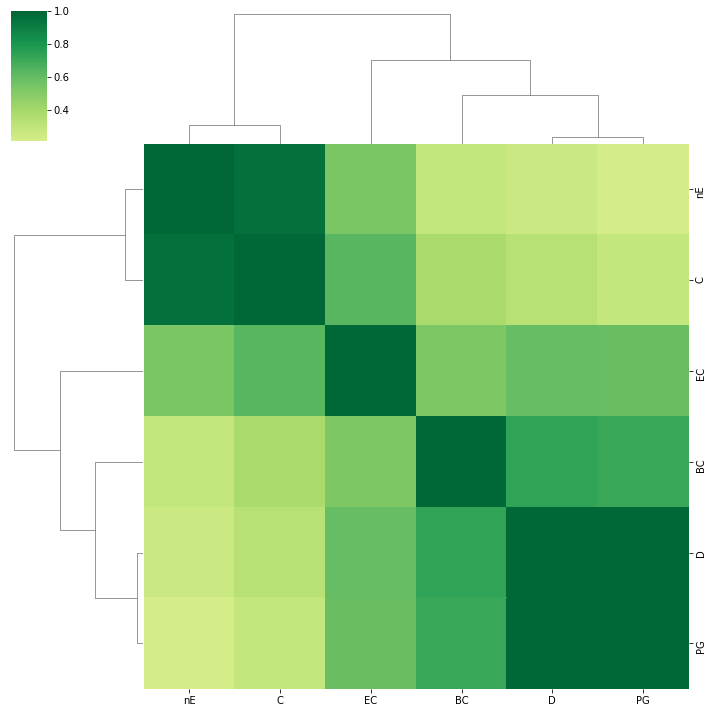

In [18]:
sns.clustermap(centralities.corr(), cmap="RdYlGn", center=0.)
plt.show()

## Spearman correlation heatmap

In [19]:
from scipy.stats import spearmanr

#spearmanr(centralities).correlation
#cen_spcorr,_ = spearmanr(centralities)
cen_spcorr = pd.DataFrame(spearmanr(centralities).correlation, index=centralities_names, columns=centralities_names)
cen_spcorr

,D,BC,nE,C,EC,PG
D,1.000000,0.921952,0.182905,0.207245,0.201538,0.976177
BC,0.921952,1.000000,0.178732,0.221216,0.184482,0.921065
nE,0.182905,0.178732,1.000000,0.971422,0.836799,0.077686
C,0.207245,0.221216,0.971422,1.000000,0.887144,0.107741
EC,0.201538,0.184482,0.836799,0.887144,1.000000,0.124996
PG,0.976177,0.921065,0.077686,0.107741,0.124996,1.000000


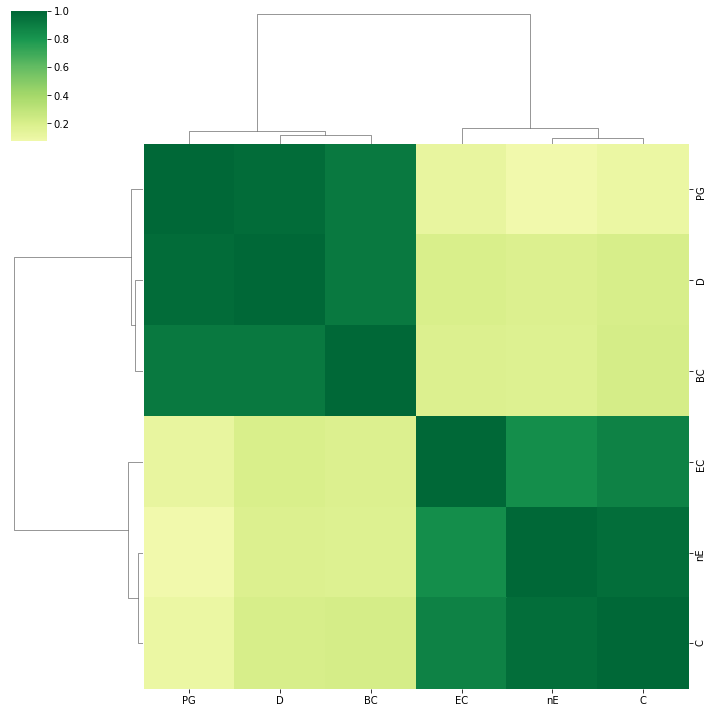

In [20]:
sns.clustermap(cen_spcorr, cmap="RdYlGn", center=0.)
plt.show()

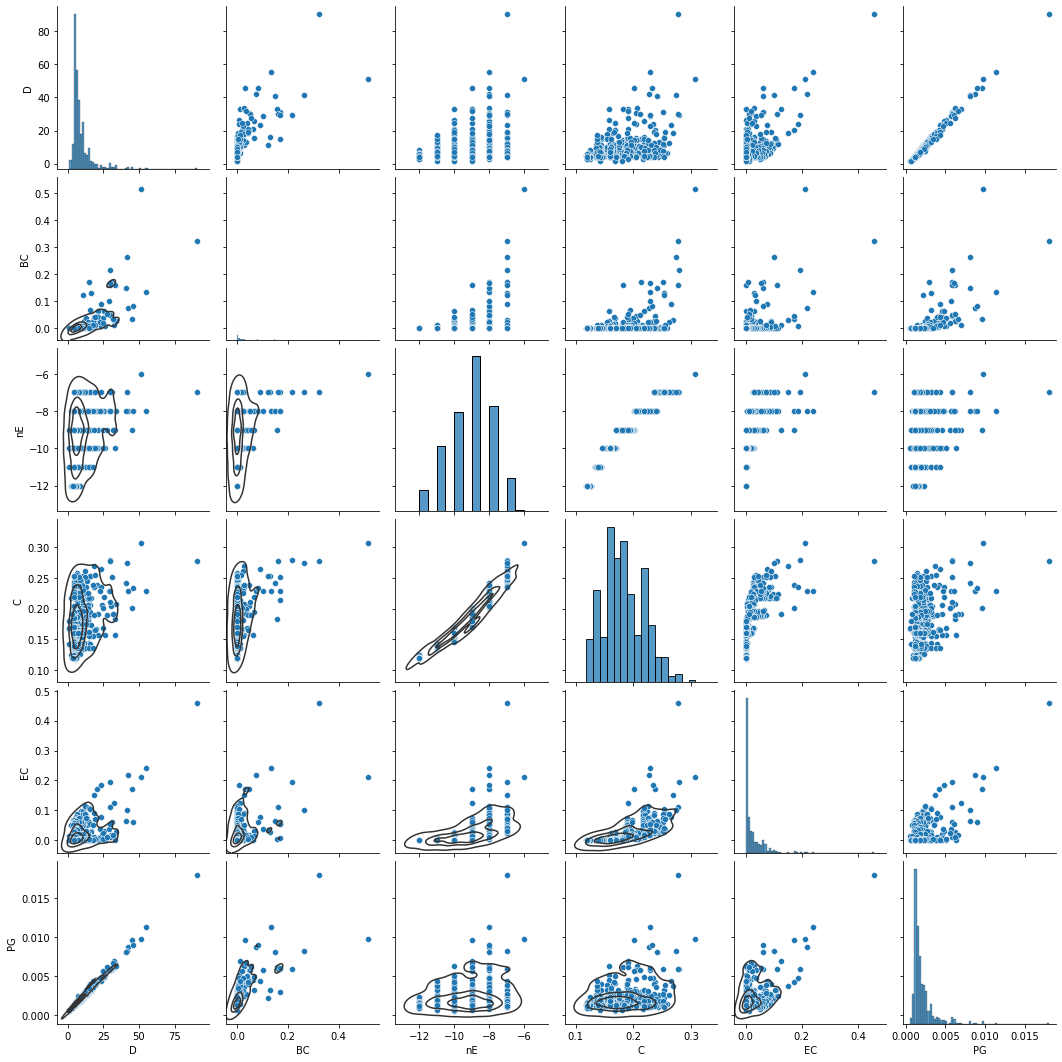

In [21]:
corr_plot = sns.pairplot(data=centralities);

corr_plot.map_lower(sns.kdeplot, levels=4, color=".2");

# Centrality Ranking
As observed in the correlation heatmaps above, the centrality measures has two separate clusters, with very high in-cluster correlation. As per Pozzi et al, we first compute the X/Y indices by averaging the ranking of centrality measures for each cluster; then use X+Y as our aggregated centrality index.


In [22]:
def XY_ranking(G):
    G1 = nx.Graph()
    weight_map = lambda w: 1+w
    for u,v,d in G.edges(data=True):
        G1.add_edge(u,v,weight=weight_map(d['weight']))
    #deg= pd.DataFrame.from_dict(dict(G1.degree(weight='weight')), orient='index', columns = ['D'])
    #deg_ranking = deg['D'].argsort().argsort()
    PG_ranking = pd.Series(nx.pagerank(G1, weight='weight')).rank()  # almost identical to degree
    EC_ranking = pd.Series(nx.eigenvector_centrality(G1, weight='weight')).rank()
    X = (PG_ranking + EC_ranking).rank()
    
    G1 = nx.Graph()
    weight_map = lambda w: np.sqrt(2*(1-w))
    for u,v,d in G0_filtered.edges(data=True):
        G1.add_edge(u,v,weight=weight_map(d['weight']))
    NE_ranking = (-pd.Series(nx.eccentricity(G1))).rank()
    CLO_ranking = pd.Series(nx.closeness_centrality(G1, distance='weight')).rank()
    BC_ranking = pd.Series(nx.betweenness_centrality(G1, weight='weight')).rank()
    Y = (NE_ranking+CLO_ranking+BC_ranking).rank()
    
    return X,Y,(X+Y).rank()

Index(['PPL', 'EIX', 'FE', 'CNP', 'COG', 'WMB', 'RE', 'NRG', 'HFC', 'WLTW',
       'WBA', 'DLTR', 'LB', 'ULTA', 'KR', 'BBY', 'HUM', 'CMG', 'MNST', 'MO',
       'UHS', 'DVA', 'CHD', 'HSY', 'MKC', 'CAG', 'TSN', 'KHC', 'SYY', 'UA'],
      dtype='object')

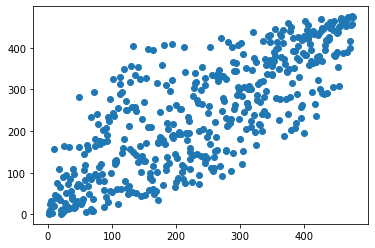

In [23]:
tx,ty,txy = XY_ranking(G0_filtered)
plt.scatter(tx,ty)
txy.index[txy<=30]

In [24]:
log_returns_df.shape

(1006, 485)

In [25]:

def shrinkage_estimator(corr, shrinkage_coef):
    shrinkage_target=np.eye(corr.shape[1])
    return corr*(1-shrinkage_coef) + shrinkage_target*shrinkage_coef

class Backtester:
    def __init__(self, basket_size, basket_update_frequency, rebalance_frequency, rolling_window):
        self.basket_size=  basket_size
        assert basket_update_frequency >= rebalance_frequency
        self.basket_update_frequency = basket_update_frequency
        self.rebalance_frequency = rebalance_frequency
        self.rolling_window = rolling_window
    
    def backtest_equal_weight(self, data):
        T, n = data.shape
        for t in range(rolling_window, T):
            if t%T == 0:
                corr = shrinkage_estimator(data.iloc[t-rolling_window:t].corr(), 1e-4)
                G = nx.from_pandas_adjacency(corr - np.diag(np.diag(corr)))
                G = PMFG(G).compute(tol_ratio=.03)   # do not save dense corr-network
                X,Y,XY = XY_ranking(G)
                low_cen_basket = XY.index[XY<=self.basket_size]
                high_cen_basket = XY.index[XY>=n-self.basket_size]
            # low_cen_returns.append(data[low_cen_basket].iloc[t].sum()/self.basket_size)